In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self,init_pose):
        self.pose = init_pose
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        

In [3]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,init_pose,num,motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particl のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
    
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録

In [4]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)# class Mclのmotion_update
        self.prev_nu,self.prev_omega = self.nu,self.omega
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        elems.append(ax.text(0,0,"hoge",fontsize = 10))

In [5]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(initial_pose,100,motion_noise_stds = {"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})
a = EstimationAgent(0.1,0.2,10.0 / 180 * math.pi,0.1)
estimator.motion_update(0.2,10.0 / 180 * math.pi,0.1)
for p in estimator.particles:
    print(p.pose)


[0.02600502 0.00026935 0.02071437]
[0.02056631 0.00021    0.02042148]
[0.02624344 0.00021998 0.01676413]
[0.01867673 0.00018195 0.01948368]
[0.02089917 0.00017796 0.01703039]
[0.01976372 0.00015956 0.01614668]
[0.02053718 0.0003104  0.03022543]
[2.10385609e-02 5.69963525e-05 5.41826157e-03]
[1.43732074e-02 7.55872240e-05 1.05176979e-02]
[0.02100292 0.00019501 0.01856924]
[0.02079352 0.00016939 0.01629204]
[0.02057639 0.00027902 0.02711865]
[0.02441243 0.00016384 0.01342286]
[0.01602716 0.00017919 0.02235932]
[0.0239335  0.00020581 0.01719834]
[0.02192635 0.00021631 0.01973037]
[0.02178721 0.00021021 0.01929583]
[0.01860455 0.00015662 0.01683658]
[0.0179226  0.00015172 0.01693026]
[0.02174097 0.00021756 0.02001285]
[0.02068946 0.00034064 0.03292614]
[1.70859564e-02 7.74035525e-05 9.06042613e-03]
[0.0167028  0.00018573 0.02223887]
[0.01390513 0.00010399 0.01495671]
[0.02778154 0.000118   0.00849496]
[2.34362989e-02 9.59703813e-05 8.18984647e-03]
[0.02103526 0.00024489 0.02328257]
[0.0251

<IPython.core.display.Javascript object>


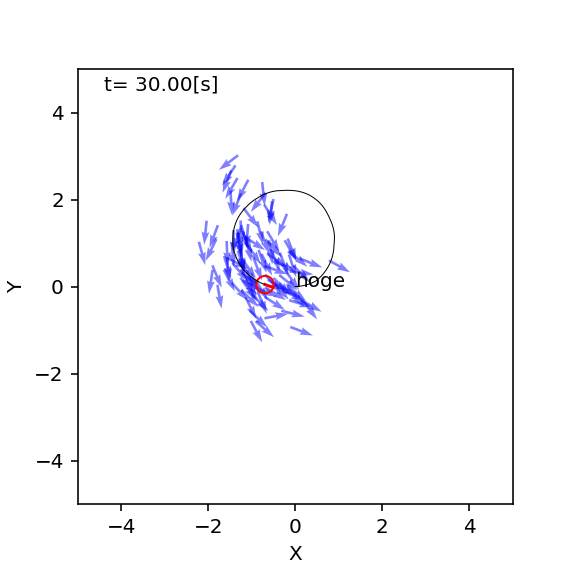

In [11]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30,time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100,motion_noise_stds)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = None,agent = circling,color = "red")
    world.append(r)
    
    world.draw()
    
trial({"nn":0.19,"no":0.001,"on":0.13,"oo":0.2})
# noiseのパラメタがテキトーなので、robotと粒子が乖離してしまう